## Load Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0 as BaseModel
from tensorflow.keras.applications.efficientnet import preprocess_input
from one_hot_encoder import one_hot_encode_sex, one_hot_encode_localization, one_hot_encode_dx

sex ['female', 'male', 'unknown']
localization ['abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk', 'unknown', 'upper extremity']
dx ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


## Constants

In [2]:
N_CLASSES_PREDICTOR = 7

# [age, sex, localization]
N_DIM_AGE = 1
N_DIM_SEX = 3
N_DIM_LOCALIZATION = 15
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

## Create Model

In [3]:
# Define two input layers
image_input = Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# 1. AGE INPUT
age_input = Input((N_DIM_AGE))

# 2. SEX INPUT
sex_input = Input((N_DIM_SEX))

# 3. LOCALIZATION INPUT
localization_input = Input((N_DIM_LOCALIZATION))

# 4. IMAGE INPUT: Convolution + Flatten for the image
base_model = BaseModel(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
base_model.trainable = False

conv_layer = base_model(image_input)
conv_input = GlobalAveragePooling2D()(conv_layer)

# Concatenate the convolutional features and the vector input
concat_layer = Concatenate()([age_input, sex_input, localization_input, conv_input])
cl_layer1 = Dense(512, activation="relu")(concat_layer)
cl_layer2 = Dense(512, activation="relu")(cl_layer1)
cl_layer3 = Dense(512, activation="relu")(cl_layer2)
output = Dense(N_CLASSES_PREDICTOR, activation="softmax")(cl_layer3)

# define a model with a list of two inputs
model = Model(inputs=[age_input, sex_input, localization_input, image_input], outputs=output)
#https://stackoverflow.com/questions/70064737/model-fit-attributeerror-tuple-object-has-no-attribute-shape
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy()])

Metal device set to: Apple M1 Max


2022-11-14 10:58:16.400961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 10:58:16.401123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3)]          0           []                           

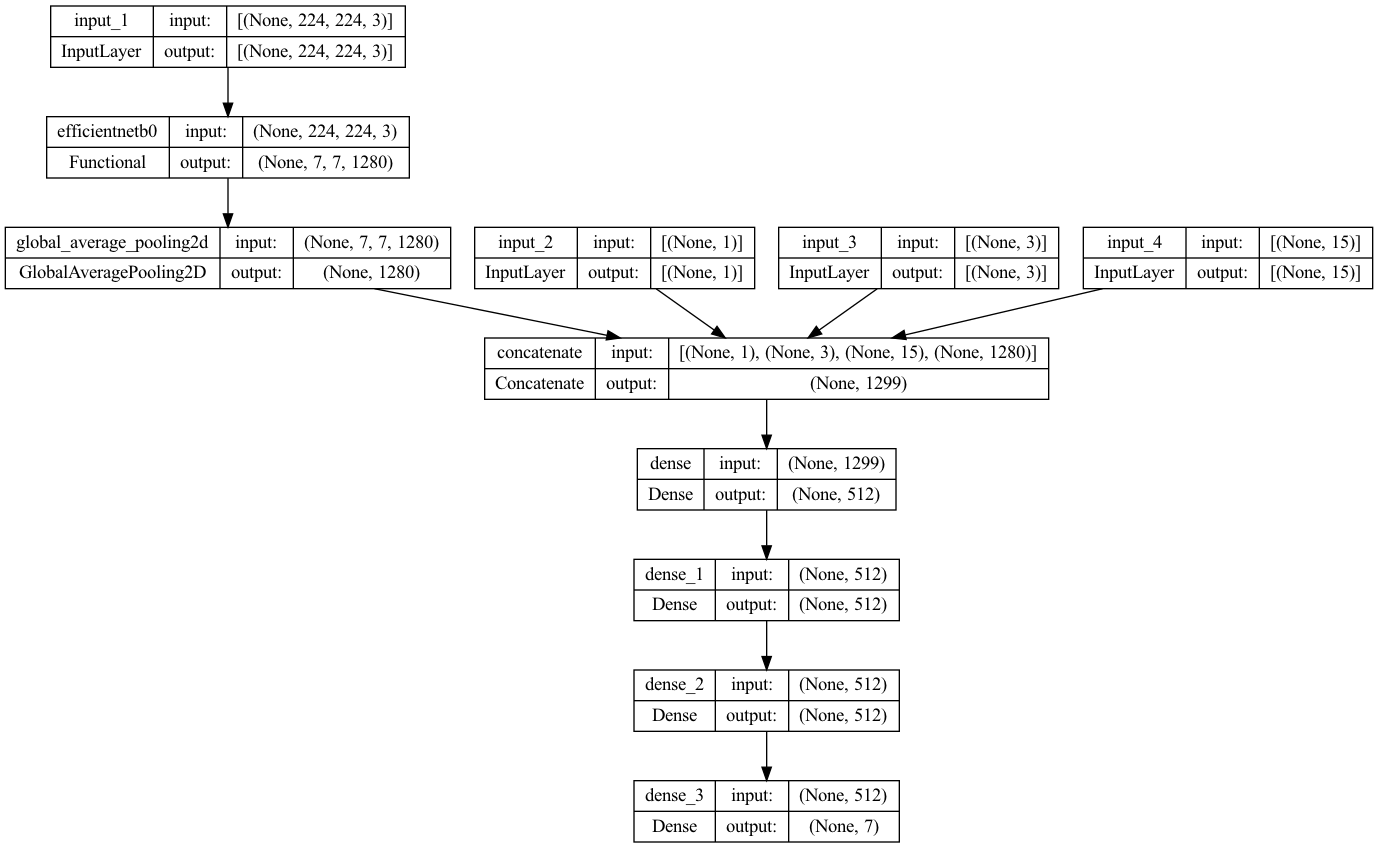

In [5]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [6]:
model.predict([np.zeros((1, N_DIM_AGE)), np.zeros((1, N_DIM_SEX)), np.zeros((1, N_DIM_LOCALIZATION)), np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))])

2022-11-14 10:58:18.364670: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-14 10:58:18.804892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


array([[0.14258355, 0.1505741 , 0.13459243, 0.15372862, 0.162673  ,
        0.12503383, 0.13081446]], dtype=float32)

## Create Data Generator

In [7]:
train_df = pd.read_csv("train.csv", delimiter=";")
validation_df = pd.read_csv("validation.csv", delimiter=";")

In [13]:
def data_generator(df, batch_size=16):
    inputs = df.image_id.values
    labels = df.dx.values.reshape(-1,1)
    
    def get_image(image_id):
        image = tf.keras.preprocessing.image.load_img("dataset/"+image_id+".jpg")
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr, [IMAGE_HEIGHT, IMAGE_WIDTH], antialias=True, method="bicubic")
        image_arr = preprocess_input(image_arr)
        return image_arr
  
    def generator():
        for image_id, label_val in zip(inputs, labels):
            one_hot_label = tf.convert_to_tensor(one_hot_encode_dx(label_val).astype(np.float32), dtype=tf.float32)
            image = tf.convert_to_tensor(get_image(image_id).numpy().astype(np.float32), dtype=tf.float32)
            age = tf.convert_to_tensor(np.array([df.loc[df['image_id'] == image_id].age.values[0].astype(np.float32)]), dtype=tf.float32)
            print(image_id)
            sex = tf.convert_to_tensor(one_hot_encode_sex(df.loc[df['image_id'] == image_id].sex.values[0]).astype(np.float32), dtype=tf.float32)
            localization = tf.convert_to_tensor(one_hot_encode_localization(df.loc[df['image_id'] == image_id].localization.values[0]).astype(np.float32), dtype=tf.float32)
            yield {"input_1": image, "input_2": age, "input_3": sex, "input_4": localization}, one_hot_label
            
    dataset = tf.data.Dataset.from_generator(generator, output_types=({"input_1": tf.float32, "input_2": tf.float32, "input_3": tf.float32, "input_4": tf.float32}, tf.float32))
    dataset = dataset.batch(batch_size)
    return dataset

In [15]:
for bt in data_generator(train_df):
    print(model.predict(bt[0]), bt[1])
    break

tf.Tensor(-2, shape=(), dtype=int64)
ISIC_0024720
ISIC_0026827
ISIC_0033037
ISIC_0026732
ISIC_0030535
ISIC_0031018
ISIC_0029572
ISIC_0026032
ISIC_0031190
ISIC_0030104
ISIC_0026595
ISIC_0024695
ISIC_0028203
ISIC_0028563
ISIC_0032694
ISIC_0028035
1/1 [==============================] - 0s 69ms/step
[[0.03840274 0.05872411 0.12637946 0.01814398 0.10677564 0.63253826
  0.01903584]
 [0.03840274 0.05872411 0.12637946 0.01814398 0.10677564 0.63253826
  0.01903584]
 [0.03840274 0.05872411 0.12637946 0.01814398 0.10677564 0.63253826
  0.01903584]
 [0.03840274 0.05872411 0.12637946 0.01814398 0.10677564 0.63253826
  0.01903584]
 [0.03840274 0.05872411 0.12637946 0.01814398 0.10677564 0.63253826
  0.01903584]
 [0.03840274 0.05872411 0.12637946 0.01814398 0.10677564 0.63253826
  0.01903584]
 [0.03840274 0.05872411 0.12637946 0.01814398 0.10677564 0.63253826
  0.01903584]
 [0.03840274 0.05872411 0.12637946 0.01814398 0.10677564 0.63253826
  0.01903584]
 [0.03840274 0.05872411 0.12637946 0.01814398 0

In [10]:
history = model.fit(data_generator(train_df, batch_size=BATCH_SIZE), epochs=1, verbose=1, validation_data=data_generator(validation_df, batch_size=BATCH_SIZE))

2022-11-14 10:58:22.979059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


ISIC_0024720
ISIC_0026827
ISIC_0033037
ISIC_0026732
ISIC_0030535
ISIC_0031018
ISIC_0029572
ISIC_0026032
ISIC_0031190
ISIC_0030104
ISIC_0026595
ISIC_0024695
ISIC_0028203
ISIC_0028563
ISIC_0032694
ISIC_0028035
ISIC_0032868
ISIC_0027119
ISIC_0024849
ISIC_0026218
ISIC_0034282
ISIC_0033187
ISIC_0029652
ISIC_0025870
ISIC_0025100
ISIC_0027255
ISIC_0024792
ISIC_0028568
ISIC_0027057
ISIC_0024641
ISIC_0026908
ISIC_0028297
      1/Unknown - 4s 4s/step - loss: 3.2589 - categorical_accuracy: 0.0000e+00ISIC_0027766
ISIC_0029317
ISIC_0031840
ISIC_0028019
ISIC_0032870
ISIC_0031242
ISIC_0025830
ISIC_0025839
ISIC_0032205
ISIC_0032209
ISIC_0027620
ISIC_0032306
ISIC_0024616
ISIC_0030148
ISIC_0033608
ISIC_0030884
ISIC_0024904
ISIC_0029068
ISIC_0024956
ISIC_0031123
ISIC_0027338
ISIC_0026181
ISIC_0030679
ISIC_0025394
ISIC_0027112
ISIC_0032954
ISIC_0025511
ISIC_0027646
ISIC_0030063
ISIC_0031663
ISIC_0025941
ISIC_0033850
      2/Unknown - 4s 755ms/step - loss: 2.5981 - categorical_accuracy: 0.3438 ISIC_0031723

KeyboardInterrupt: 

In [ ]:
for bt in validation_generator:
    print(bt[0][3][0][0][0][:2], bt[0][3][1][0][0][:2])
    print(model.predict(bt[0]))
    break